### Test

# I. Import the required libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# II. Loading the data

In [2]:
df = pd.read_csv('Downloads/loan.csv', low_memory=False)

## Set display options for pandas (Show all columns, flexible column width)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# III. Cleaning data

## 3.1. Dropping columns

### 3.1.1. List out the columns that has missing values

In [4]:
df.isnull().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
                              ...  
tax_liens                        39
tot_hi_cred_lim               39717
total_bal_ex_mort             39717
total_bc_limit                39717
total_il_high_credit_limit    39717
Length: 111, dtype: int64

### Remove all the columns in which percentage of missing values is greater than 80%

In [5]:
total_rows = df.shape[0];
to_be_removed_columns = [];
for col_name, sum_of_null_value in df.isnull().sum().iteritems():
    if (sum_of_null_value / total_rows >= 0.8):
        to_be_removed_columns.append(col_name)

df.drop(columns=to_be_removed_columns, inplace=True)

### 3.1.2. Drop customer behavior columns
The Customer behavior variables are not available at the time of loan application, and thus they cannot be used as predictor for credit approval

In [6]:
customer_behavior_columns = [
    'delinq_2yrs',
    'earliest_cr_line',
    'inq_last_6mths',
    'open_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_int',
    'total_rec_prncp',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d'
]
df.drop(columns=customer_behavior_columns, inplace=True)

### 3.1.3. Drop another columns

1. Checking through the `application_type`, the only value is `INDIVIDUAL`
So all the records are invidual application, not joint, we will remove all the columns that indicates co-borrowers. Those are:
- `annual_inc_joint`
- `dti_joint`
- `verified_status_joint`

And we should remove the `application_type` as well, as the column contains only 1 value

In [7]:
df.drop(
    columns=['annual_inc_joint', 'dti_joint', 'verified_status_joint', 'application_type'],
    errors='ignore', 
    inplace=True
)

2. List out the columns with unique value count

In [8]:
df.nunique()

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
desc                          26527
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
mths_since_last_delinq           95
initial_list_status               1
collections_12_mths_ex_med  

We should remove the columns with count of unique value is 1, as it will have no effect on the analysis

In [9]:
to_be_removed_columns = [];
for col_name, unique_value in df.nunique().iteritems():
    if (unique_value == 1):
        to_be_removed_columns.append(col_name)
        
df.drop(columns=to_be_removed_columns, inplace=True)

The `url` and `desc` is also unneeded for analysis. Let's remove them

In [10]:
df.drop(columns=['url', 'desc'], inplace=True)

Since the `purpose` is clearer and it can includes the meaning of `title`, let's remove `title` as well

In [11]:
df.drop(columns=['title'], inplace=True)

## 3.2. Cleaning rows

### 3.2.1. Removing `Current` loan status

We will remove the rows with `loan_status` is `Current` because we only need to analyze loans that are ended (`Fully Paid` or `Charge Off`)

In [12]:
df = df[df.loan_status != 'Current']

### 3.2.2. Removing outliers

Check for `annual_inc` column:

<AxesSubplot:>

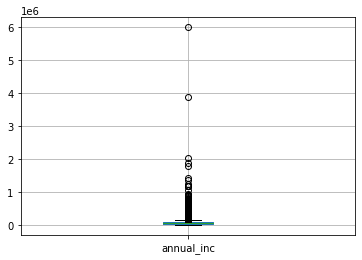

In [13]:
df.boxplot(column=['annual_inc'])

We can see in the above boxplot for `annual_inc`, the max value is too high compare to the upper threshold, we need to remove those outliers

In [14]:
df = df[df.annual_inc < df.annual_inc.quantile(0.99)]

<AxesSubplot:>

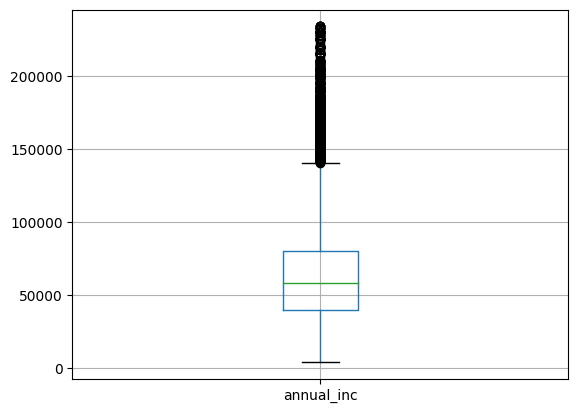

In [15]:
df.boxplot(column=['annual_inc'])

The boxplot is now easier to look at

### 3.2.3. Convert data to correct type

Check data type of all columns

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38191 entries, 0 to 39716
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      38191 non-null  int64  
 1   member_id               38191 non-null  int64  
 2   loan_amnt               38191 non-null  int64  
 3   funded_amnt             38191 non-null  int64  
 4   funded_amnt_inv         38191 non-null  float64
 5   term                    38191 non-null  object 
 6   int_rate                38191 non-null  object 
 7   installment             38191 non-null  float64
 8   grade                   38191 non-null  object 
 9   sub_grade               38191 non-null  object 
 10  emp_title               35846 non-null  object 
 11  emp_length              37163 non-null  object 
 12  home_ownership          38191 non-null  object 
 13  annual_inc              38191 non-null  float64
 14  verification_status     38191 non-null

#### - `int_rate` (Interest rate) should be a number

In [17]:
df.int_rate.value_counts()

10.99%    904
11.49%    786
7.51%     782
13.49%    744
7.88%     717
         ... 
16.96%      1
18.36%      1
16.15%      1
16.01%      1
16.20%      1
Name: int_rate, Length: 370, dtype: int64

Let's remove the % mark and convert it to number

In [18]:
df.int_rate = pd.to_numeric(df.int_rate.apply(lambda x: x.replace('%', '')))

df.int_rate.describe()

#### - `issue_d` (The issuing date must be a date)

In [19]:
df.issue_d.value_counts() #Check format of datetime

Nov-11    2045
Dec-11    2025
Oct-11    1913
Sep-11    1891
Aug-11    1781
Jul-11    1730
Jun-11    1709
May-11    1593
Apr-11    1548
Mar-11    1427
Jan-11    1369
Feb-11    1287
Dec-10    1255
Oct-10    1117
Nov-10    1114
Jul-10    1112
Sep-10    1075
Aug-10    1073
Jun-10    1020
May-10     908
Apr-10     819
Mar-10     722
Feb-10     617
Nov-09     592
Dec-09     588
Jan-10     580
Oct-09     539
Sep-09     447
Aug-09     405
Jul-09     367
Jun-09     350
May-09     316
Apr-09     286
Mar-09     276
Feb-09     259
Jan-09     237
Mar-08     234
Dec-08     222
Nov-08     183
Feb-08     174
Jan-08     168
Apr-08     155
Oct-08      94
Dec-07      85
Jul-08      83
Aug-08      71
May-08      70
Jun-08      66
Oct-07      46
Nov-07      35
Aug-07      33
Sep-08      32
Jul-07      29
Sep-07      18
Jun-07       1
Name: issue_d, dtype: int64

In [20]:
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%y')

### 3.2.4. Imputing data

**Check for missing values**

In [21]:
df.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2345
emp_length                 1028
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
mths_since_last_delinq    24676
pub_rec_bankruptcies        688
dtype: int64

In [22]:
df.shape

(38191, 23)

***Since the total rows with missing value for `emp_length` is low (1028 compare to 39319). Let's remove those rows***

In [23]:
df = df[df.emp_length.notnull()]

In [25]:
df['emp_title'] = df['emp_title'].fillna('None') # Also fill None to the missing `emp_title`

In [26]:
df.isnull().sum() # Check missing value again

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
mths_since_last_delinq    23978
pub_rec_bankruptcies        688
dtype: int64

***Now the data is ready for analysis***

In [46]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,mths_since_last_delinq,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,NaN,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.00,NaN,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,NaN,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.00,35.0,0.0
5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,wedding,852xx,AZ,11.20,NaN,0.0


In [47]:
df.shape

(37163, 23)

# IV. Data analysis

## 4.1. Loan status insights

Let's take a look on the `loan_status`

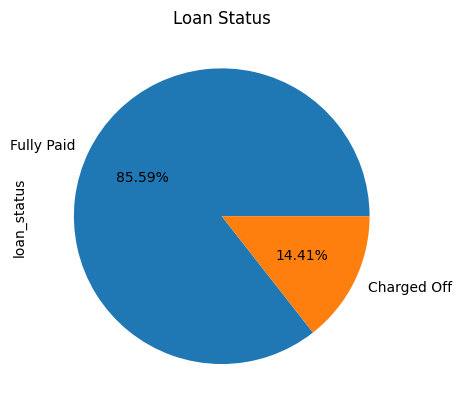

In [49]:
df.loan_status.value_counts().plot(kind='pie', title='Loan Status', autopct=lambda pct: '%.2f' % pct + '%')
plt.show()

#### Insights
- Among 37163 loan applications, 14.41% was charged off

## 4.2. Loans amount vs Loan Status

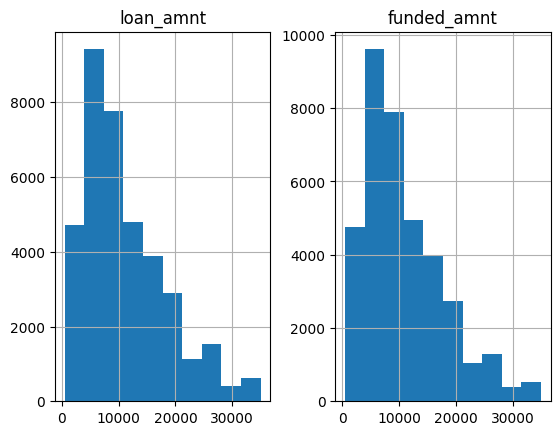

In [59]:
df.hist(column=['loan_amnt', 'funded_amnt'])
plt.show()

#### Insights
People seems to apply most for the loan range from 4500 - 7000